In [1]:
# set up Python environment: numpy for numerical routines, and matplotlib for plotting
import numpy as np
import cv2
import math
import matplotlib.pyplot as plt
# display plots in this notebook
%matplotlib inline

# set display defaults
plt.rcParams['figure.figsize'] = (10, 10)        # large images
plt.rcParams['image.interpolation'] = 'nearest'  # don't interpolate: show square pixels
plt.rcParams['image.cmap'] = 'gray'  # use grayscale output rather than a (potentially misleading) color heatmapF

import sys
import caffe
# If you get "No module named _caffe", either you have not built pycaffe or you have the wrong path.

###  load weights, graph and mean file:

In [3]:
PATCH_SIZE = 100

WEIGHTS_FILE = '/home/jing/Documents/CNN_tabletennis/end2end_vgg_iter_10000.caffemodel'
#DEPLOY_FILE = '/home/jing/Documents/CNN_tabletennis/models/sodlt_deploy.prototxt'
DEPLOY_FILE = '/home/jing/Documents/CNN_tabletennis/models/end2end_deploy_vgg.prototxt'
MEAN_FILE = '/home/jing/Documents/CNN_tabletennis/data/mean.npy'

mu = np.load(MEAN_FILE)
mu = mu.mean(1).mean(1)
print mu

net = caffe.Net(DEPLOY_FILE, WEIGHTS_FILE, caffe.TEST)

transformer = caffe.io.Transformer({'data':net.blobs['data'].data.shape})
transformer.set_transpose('data', (2,0,1))#nChannels w h?
transformer.set_mean('data', mu)
transformer.set_raw_scale('data', 255)
transformer.set_channel_swap('data', (2,1,0))#RGB to BGR

[ 116.1987664    86.25564234   87.22195852]


### load image and groud truth probability map:

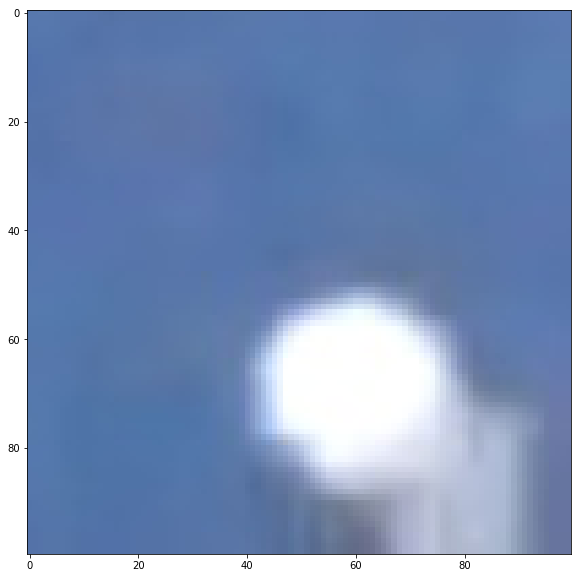

In [11]:
img_name = '/home/jing/Documents/TableTennis/TableTennis/build/tabletennis_test/0015R027705.jpg'
prob_name = '/home/jing/Documents/TableTennis/TableTennis/build/tabletennis_test/0015R027705.prob.jpg'

image = caffe.io.load_image(img_name)
plt.imshow(image)

### forward the net, show predicted probability map:

0.000136102 0.975852
[[-2.91557455  2.7548883 ]]


(-0.5, 49.5, 49.5, -0.5)

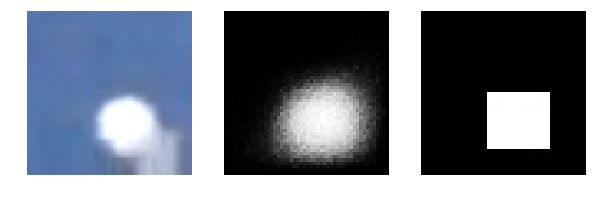

In [12]:
transformed_image = transformer.preprocess('data', image)
net.blobs['data'].data[0,...] = transformed_image

output = net.forward()

sodlt = net.blobs['sodlt_norm'].data[0][0]
print np.min(sodlt), np.max(sodlt)
cls = net.blobs['cls_fc8'].data
print cls

plt.subplot(1, 3, 1)
plt.imshow(image); plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(sodlt); plt.axis('off')
plt.subplot(1, 3, 3)

prob = caffe.io.load_image(prob_name)
plt.imshow(prob); plt.axis('off')

### The roi layer predicts a bounding box from the probability map:

[ 17.  22.  42.  45.]
0.975852


(-0.5, 49.5, 49.5, -0.5)

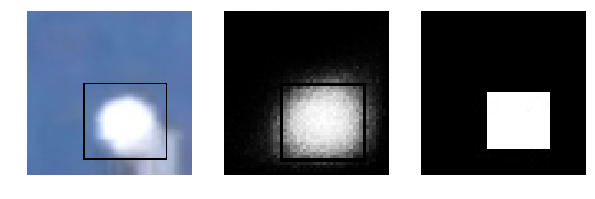

In [13]:
(x1,y1,x2,y2) = bbox = output['roi'][0]
prob_max = output['prob_max'][0]

print bbox
print prob_max

plt.subplot(1, 3, 1)
output_img = image.copy()
cv2.rectangle(output_img, (int(x1*2),int(y1*2)), (int(x2*2), int(y2*2)), (0,0,255), 1)
plt.imshow(output_img); plt.axis('off')

plt.subplot(1, 3, 3)
prob = caffe.io.load_image(prob_name)
plt.imshow(prob); plt.axis('off')

plt.subplot(1, 3, 2)
output_prob_map = sodlt.copy()
cv2.rectangle(output_prob_map, (int(x1),int(y1)), (int(x2), int(y2)), (0,0,128), 1)
plt.imshow(output_prob_map); plt.axis('off')

### show the probability map in 3D space:

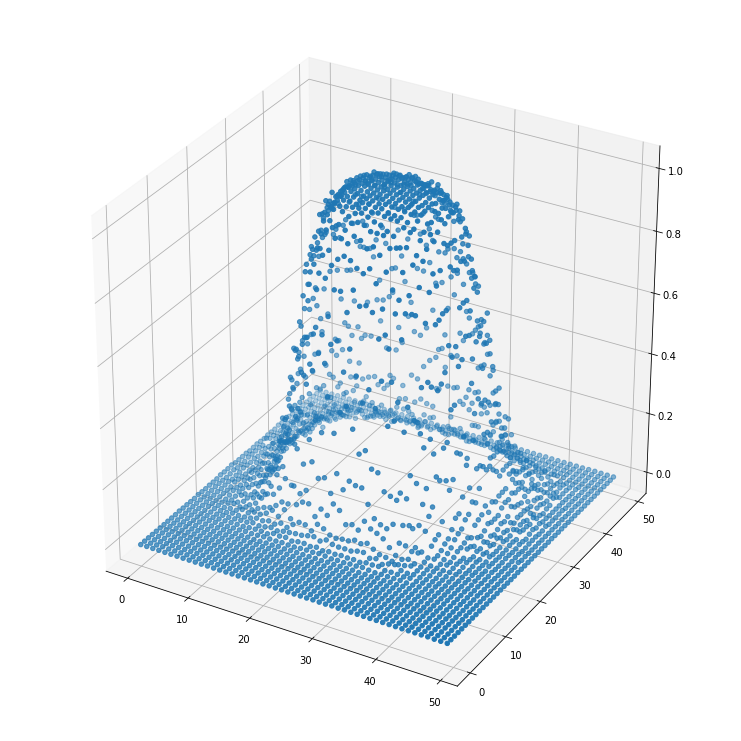

In [8]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = Axes3D(fig)
x = np.arange(0,50)
y = np.arange(0,50)
x, y = np.meshgrid(x,y)
ax.scatter(x,y,sodlt)
plt.show()

### Architecture of the SO-DLT network:

In [9]:
# for each layer, show the output shape
for layer_name, blob in net.blobs.iteritems():
    print layer_name + '\t' + str(blob.data.shape)

data	(1, 3, 100, 100)
conv1_1	(1, 64, 100, 100)
conv1_2	(1, 64, 100, 100)
pool1	(1, 64, 50, 50)
conv2_1	(1, 128, 50, 50)
conv2_2	(1, 128, 50, 50)
pool2	(1, 128, 25, 25)
conv3_1	(1, 256, 25, 25)
conv3_2	(1, 256, 25, 25)
conv3_3	(1, 256, 25, 25)
pool3	(1, 256, 13, 13)
conv4_1	(1, 512, 13, 13)
conv4_2	(1, 512, 13, 13)
conv4_3	(1, 512, 13, 13)
pool4	(1, 512, 7, 7)
conv5_1	(1, 512, 7, 7)
conv5_2	(1, 512, 7, 7)
conv5_3	(1, 512, 7, 7)
conv5_3_relu5_3_0_split_0	(1, 512, 7, 7)
conv5_3_relu5_3_0_split_1	(1, 512, 7, 7)
cls_pool5	(1, 512, 3, 3)
pool5	(1, 2560)
sodlt_fc6	(1, 4096)
sodlt_fc7	(1, 1024)
sodlt_fc8	(1, 2500)
sodlt	(1, 1, 50, 50)
sodlt_norm	(1, 1, 50, 50)
roi	(1, 4)
prob_max	(1,)
cls_fc6	(1, 4096)
cls_fc7	(1, 4096)
cls_fc8	(1, 2)


In [10]:
for layer_name, param in net.params.iteritems():
    print layer_name + '\t' + str(param[0].data.shape), str(param[1].data.shape)

conv1_1	(64, 3, 3, 3) (64,)
conv1_2	(64, 64, 3, 3) (64,)
conv2_1	(128, 64, 3, 3) (128,)
conv2_2	(128, 128, 3, 3) (128,)
conv3_1	(256, 128, 3, 3) (256,)
conv3_2	(256, 256, 3, 3) (256,)
conv3_3	(256, 256, 3, 3) (256,)
conv4_1	(512, 256, 3, 3) (512,)
conv4_2	(512, 512, 3, 3) (512,)
conv4_3	(512, 512, 3, 3) (512,)
conv5_1	(512, 512, 3, 3) (512,)
conv5_2	(512, 512, 3, 3) (512,)
conv5_3	(512, 512, 3, 3) (512,)
sodlt_fc6	(4096, 2560) (4096,)
sodlt_fc7	(1024, 4096) (1024,)
sodlt_fc8	(2500, 1024) (2500,)
cls_fc6	(4096, 4608) (4096,)
cls_fc7	(4096, 4096) (4096,)
cls_fc8	(2, 4096) (2,)


### Visualize some weights and data in the network

In [11]:
def vis_square(data):
    """Take an array of shape (n, height, width) or (n, height, width, 3)
       and visualize each (height, width) thing in a grid of size approx. sqrt(n) by sqrt(n)"""
    
    # normalize data for display
    data = (data - data.min()) / (data.max() - data.min())
    
    # force the number of filters to be square
    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = (((0, n ** 2 - data.shape[0]),
               (0, 1), (0, 1))                 # add some space between filters
               + ((0, 0),) * (data.ndim - 3))  # don't pad the last dimension (if there is one)
    data = np.pad(data, padding, mode='constant', constant_values=1)  # pad with ones (white)
    
    # tile the filters into an image
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    
    plt.imshow(data); plt.axis('off')

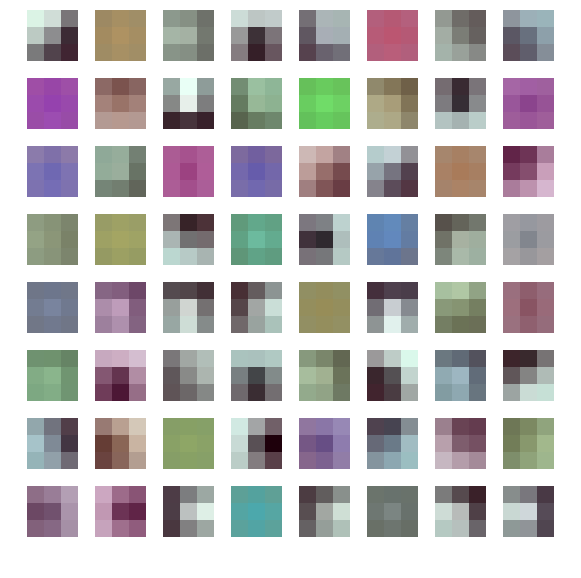

In [13]:
# the parameters are a list of [weights, biases]
filters = net.params['conv1_1'][0].data
vis_square(filters.transpose(0, 2, 3, 1))

In [ ]:
def sort_and_vis(data, n):
    """Take an array of shape (n, height, width), sort by activation 
       and visualize each (height, width) thing in a grid of size approx. sqrt(n) by sqrt(n)"""
    
    # normalize data for display
    data = (data - data.min()) / (data.max() - data.min())
    
    # force the number of filters to be square
    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = (((0, n ** 2 - data.shape[0]),
               (0, 1), (0, 1))                 # add some space between filters
               + ((0, 0),) * (data.ndim - 3))  # don't pad the last dimension (if there is one)
    data = np.pad(data, padding, mode='constant', constant_values=1)  # pad with ones (white)
    
    # tile the filters into an image
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    
    plt.imshow(data); plt.axis('off')

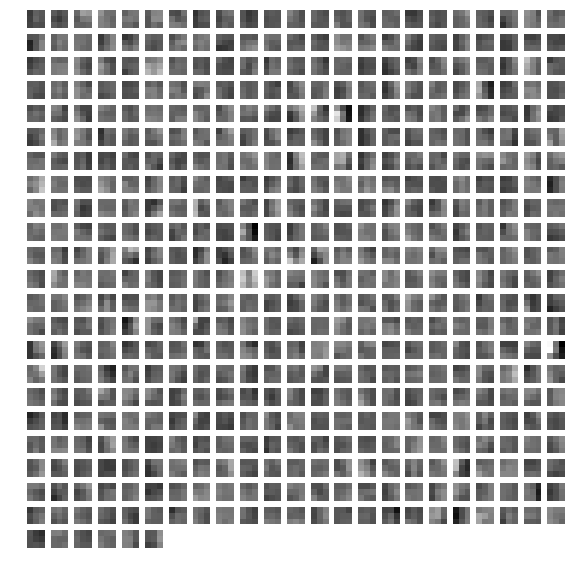

In [15]:
filters = net.params['conv5_2'][0].data
vis_square(filters[1])

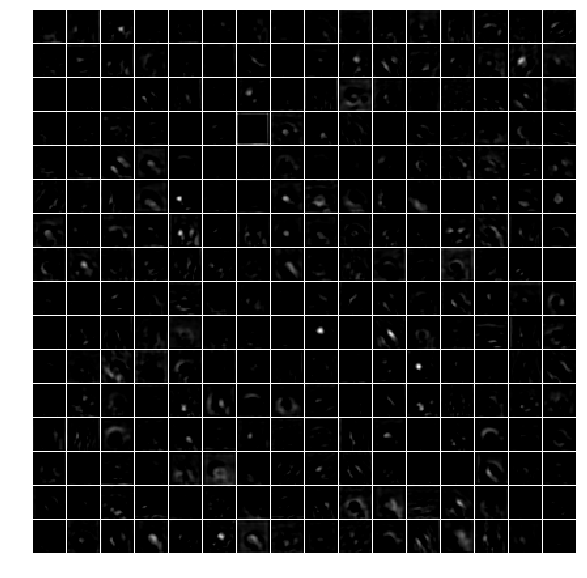

In [20]:
feat = net.blobs['conv3_3'].data[0]
vis_square(feat)

### The deprecated method of extracting bounding box from probability map:

(-0.5, 49.5, 49.5, -0.5)

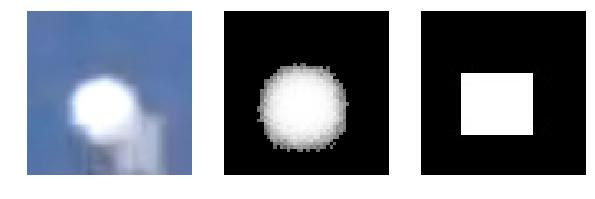

In [21]:
sodlt[sodlt<0.4] = 0

plt.subplot(1, 3, 1)
plt.imshow(image); plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(sodlt); plt.axis('off')
plt.subplot(1, 3, 3)

prob = caffe.io.load_image(prob_name)
plt.imshow(prob); plt.axis('off')

### Find contour:

In [22]:
sodlt_int = (sodlt*255).astype(np.uint8)
output_img = image.copy()
npaContours, npaHierarchy = cv2.findContours(sodlt_int.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

for npaContour in npaContours:
    if cv2.contourArea(npaContour) > 10:
        [x,y,w,h] = cv2.boundingRect(npaContour)
        cv2.rectangle(output_img, (x*2,y*2), ((x+w)*2, (y+h)*2), (0,0,255), 1)

(-0.5, 99.5, 99.5, -0.5)

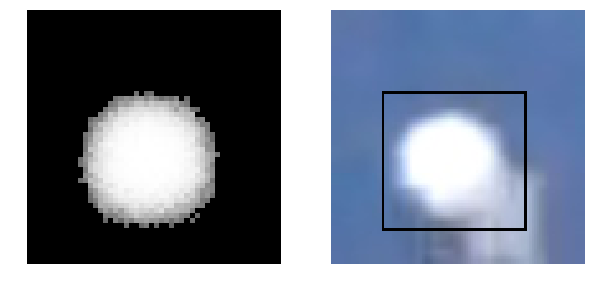

In [23]:
plt.subplot(1, 2, 1)
plt.imshow(sodlt); plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(output_img); plt.axis('off')

In [33]:
#speed
net.forward()  # run once before timing to set up memory
%timeit net.forward()

10 loops, best of 3: 34.1 ms per loop
